# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [3]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


1. change column headers to something workable
2. create a datetime index 

In [4]:
df.columns = ['Month','Milk in Pounds per Cow']

In [5]:
df.head()

,Month,Milk in Pounds per Cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [6]:
df.tail()

,Month,Milk in Pounds per Cow
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [7]:
df.drop(168, axis=0, inplace=True)
#remove wierd footer on the end of data

In [8]:
df['Month'] = pd.to_datetime(df['Month'])

In [9]:
df.head()

,Month,Milk in Pounds per Cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [10]:
df.set_index('Month', inplace=True)

In [11]:
df.head()
# data is cleaned up and we have time series as index and short column headers

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [12]:
df.describe().transpose()
#basic statistics on our data set

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


# Visualization of Data

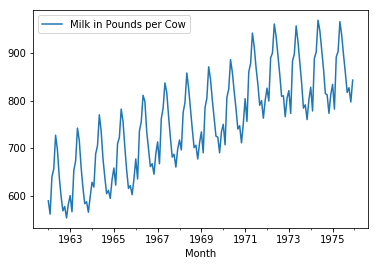

In [13]:
df.plot()

In [14]:
time_series = df['Milk in Pounds per Cow']

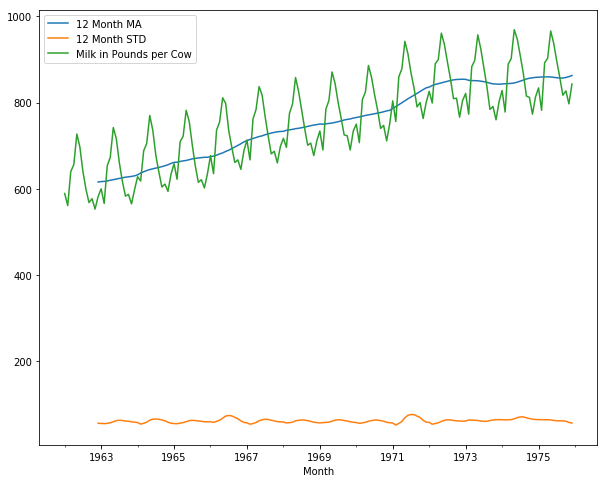

In [15]:
time_series.rolling(12).mean().plot(label='12 Month MA',figsize=(10,8))
#simple moving average over a 12 month period
time_series.rolling(12).std().plot(label='12 Month STD')
time_series.plot()
plt.legend();

#### In this plot you can visulize the linear grwoth trend line over the seasonality. The variance (std dev) shows consistent production.

# Error, Trend and Seasonality Decomposition

### I want to deconstruct the time series data to these 3 parts to better understand how much of this production is attributable to regularly seasonality, and how strong the real trend of production is so that I can understand risk variance and make operational decisions.

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
#default to additive model, frequency set to 12
decomp = seasonal_decompose(time_series,freq=12)

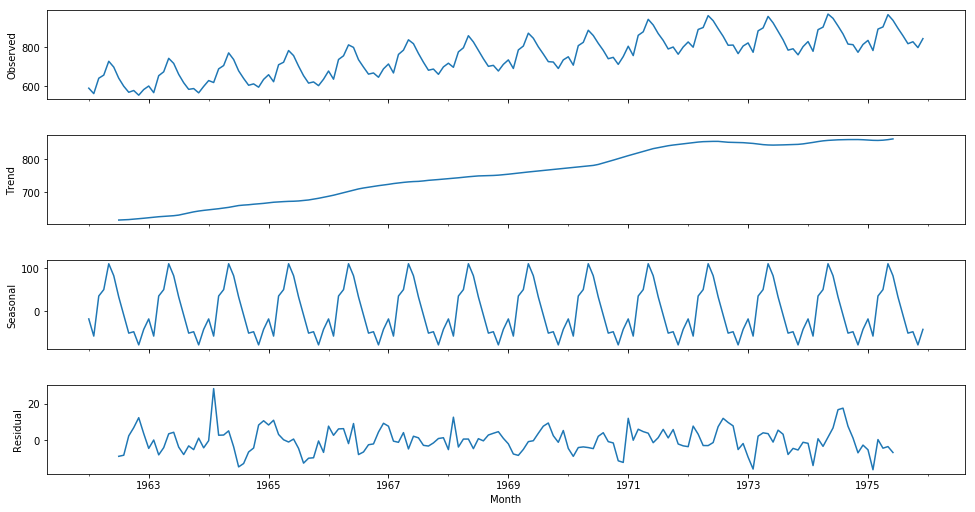

In [18]:
fig = decomp.plot()
fig.set_size_inches(15,8)

# Test stationary data using Augmented Dicky-Fuller Test
In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, I am trying to see whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
result = adfuller(df['Milk in Pounds per Cow'])

In [21]:
def adf_check(time_series):
    result = adfuller(time_series)
    print(' Augmented Dicky-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value', '# of lags','num of obs used']
    
    for value,label in zip(result,labels):
        print(label+ ": "+str(value))
    
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('reject null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root, it is non-stationary')

In [22]:
adf_check(time_series)

 Augmented Dicky-Fuller Test
ADF Test Statistic: -1.3038115874221246
p-value: 0.627426708603034
# of lags: 13
num of obs used: 154
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


# difference the data since it is non-stationary

In [23]:
df['First Difference'] = df['Milk in Pounds per Cow']- df['Milk in Pounds per Cow'].shift(1)

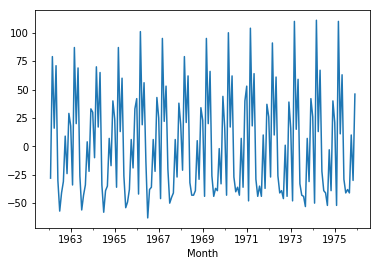

In [24]:
df['First Difference'].plot()
#The trend is flattening out and data is becoming stationary 

In [25]:
# check if onnce is enough
adf_check(df['First Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic: -3.0549955586530553
p-value: 0.03006800400178688
# of lags: 14
num of obs used: 152
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


In [26]:
df['Seasonal Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(12)

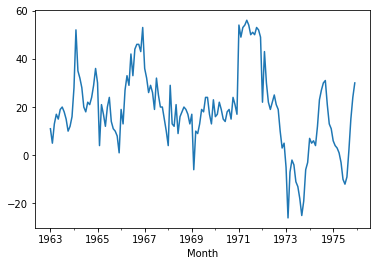

In [27]:
df['Seasonal Difference'].plot()

In [28]:
#non stationary ; vriance increases over time
adf_check(df['Seasonal Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic: -2.3354193143593993
p-value: 0.16079880527711304
# of lags: 12
num of obs used: 143
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


In [29]:
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)

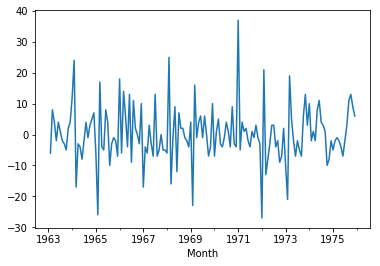

In [30]:
df['Seasonal First Difference'].plot()

In [31]:
adf_check(df['Seasonal First Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic: -5.038002274921985
p-value: 1.86542343187882e-05
# of lags: 11
num of obs used: 143
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


# Correlation and Partial-Autocorrelation

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

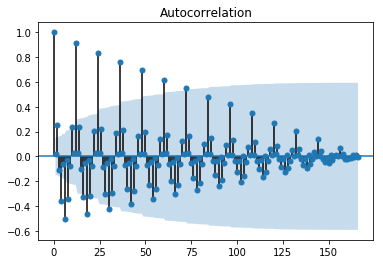

In [33]:
fig_first = plot_acf(df['First Difference'].dropna())
#gradual decline

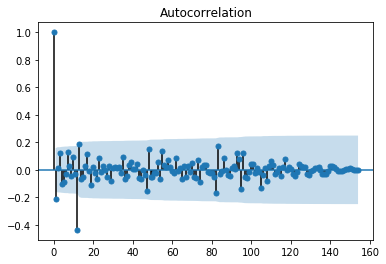

In [34]:
fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

/Users/fabian/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


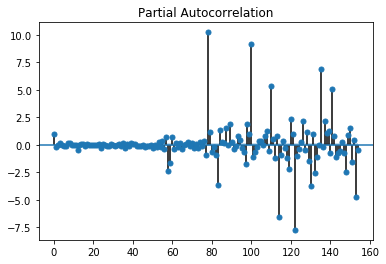

In [35]:
fig_seasonal_first = plot_pacf(df['Seasonal First Difference'].dropna())

In [36]:
from statsmodels.tsa.arima_model import ARIMA

In [37]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

In [42]:
model = sm.tsa.statespace.SARIMAX(df['Milk in Pounds per Cow'],order=(0,1,0),seasonal_order=(1,1,1,12))

/Users/fabian/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [45]:
results = model.fit()

In [46]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Thu, 28 Jun 2018   AIC                           1074.131
Time:                                    14:08:54   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

In [47]:
results.resid
#errors of predictions

Month
1962-01-01    589.000000
1962-02-01    -28.000000
1962-03-01     79.000000
1962-04-01     16.000000
1962-05-01     71.000000
1962-06-01    -30.000000
1962-07-01    -57.000000
1962-08-01    -41.000000
1962-09-01    -31.000000
1962-10-01      9.000000
1962-11-01    -24.000000
1962-12-01     29.000000
1963-01-01   -276.500828
1963-02-01     -6.001008
1963-03-01      8.002845
1963-04-01      4.000576
1963-05-01     -1.997443
1963-06-01      3.998920
1963-07-01      0.997947
1963-08-01     -2.001476
1963-09-01     -3.001116
1963-10-01     -4.999676
1963-11-01      1.999136
1963-12-01      4.001044
1964-01-01     11.980057
1964-02-01     21.216689
1964-03-01    -13.288290
1964-04-01     -1.144499
1964-05-01     -4.926558
1964-06-01     -6.145193
                 ...    
1973-07-01      0.055663
1973-08-01     -6.173434
1973-09-01     -9.576197
1973-10-01      2.410418
1973-11-01      6.632694
1973-12-01      3.259520
1974-01-01      0.696354
1974-02-01     -9.375255
1974-03-01     10.3

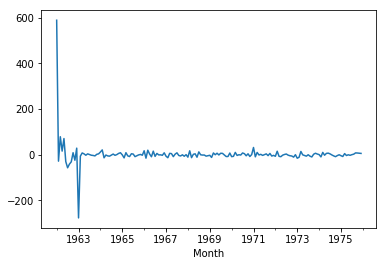

In [48]:
results.resid.plot()

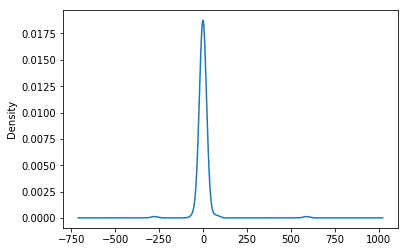

In [49]:
results.resid.plot(kind='kde')

### Residual errors of ARIMA model fit are very tightly centered around 0. 

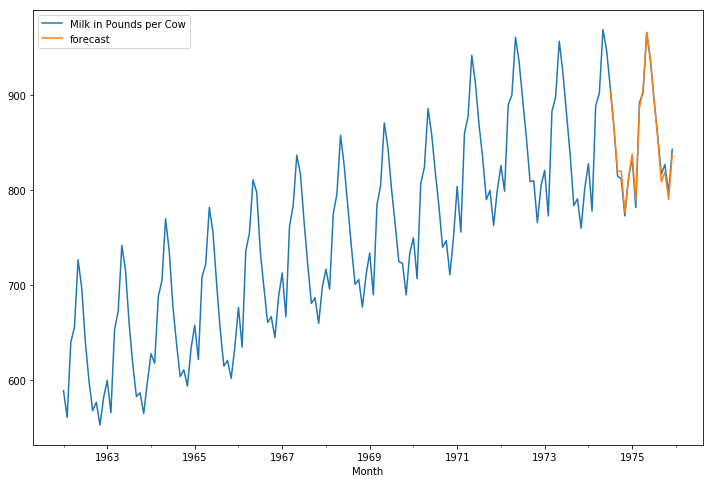

In [67]:
df['forecast'] = results.predict(start=150,end=168)
df[['Milk in Pounds per Cow', 'forecast']].plot(figsize=(12,8))
# this is a trail forecast on data points we already have to see the fit of the model.
# tiny errors on seasonality change points


# Forecast further 

In [70]:
df.tail()
#need to add more months with empty values for forecasting

,Milk in Pounds per Cow,First Difference,Seasonal Difference,Seasonal First Difference,forcast,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,-9.0,3.0,855.358648,855.358648
1975-09-01,817.0,-41.0,2.0,11.0,808.841372,808.841372
1975-10-01,827.0,10.0,15.0,13.0,819.323185,819.323185
1975-11-01,797.0,-30.0,24.0,9.0,790.427530,790.427530
1975-12-01,843.0,46.0,30.0,6.0,837.063622,837.063622


In [55]:
from pandas.tseries.offsets import DateOffset

In [56]:
future_dates = [df.index[-1] + DateOffset(months=x)for x in range(1,24)]

In [57]:
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [75]:
future_df = pd.DataFrame(index=future_dates,columns=df.columns)

In [77]:
future_df

,Milk in Pounds per Cow,First Difference,Seasonal Difference,Seasonal First Difference,forecast
1976-01-01,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN
1976-06-01,NaN,NaN,NaN,NaN,NaN
1976-07-01,NaN,NaN,NaN,NaN,NaN
1976-08-01,NaN,NaN,NaN,NaN,NaN
1976-09-01,NaN,NaN,NaN,NaN,NaN
1976-10-01,NaN,NaN,NaN,NaN,NaN


In [78]:
final_df = pd.concat([df,future_df])

In [79]:
final_df.head()

,Milk in Pounds per Cow,First Difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN
1962-03-01,640.0,79.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,NaN,NaN,NaN


In [80]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN


In [81]:
final_df['forecast'] = results.predict(start=168,end=192)

In [82]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,951.525867
1977-08-01,NaN,NaN,NaN,NaN,911.918957
1977-09-01,NaN,NaN,NaN,NaN,865.881182
1977-10-01,NaN,NaN,NaN,NaN,871.027295
1977-11-01,NaN,NaN,NaN,NaN,836.962996


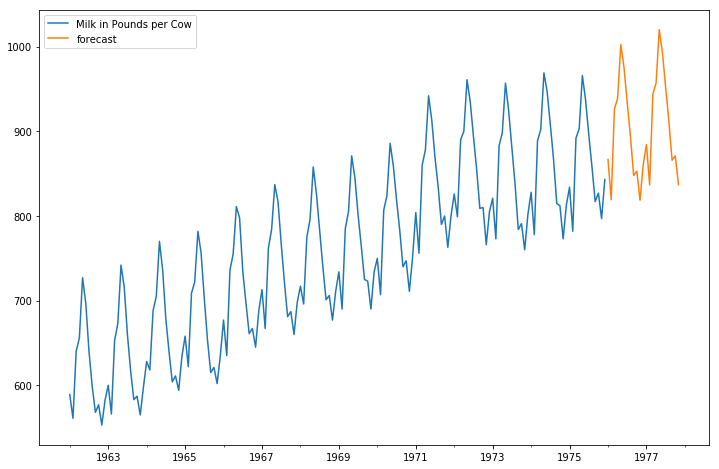

In [84]:
final_df[['Milk in Pounds per Cow','forecast']].plot(figsize=(12,8));